# Deep learning in genomics - Basic model with PyTorch and fastai

This notebook is based on the [jupyter notebook](https://nbviewer.jupyter.org/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [78]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [79]:
from fastai import *
from fastai.vision import *

In [80]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [81]:
# fastai version
__version__

'1.0.36.post1'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [82]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [83]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


### Target setup

In [84]:
targA = seq_df['Target'].values.astype(int); targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [85]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [86]:
seq_df['NotTarget'] = targB

In [87]:
seq_df.head()

,Sequences,Target,NotTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,0


## fastai data object

### Setup custom fastai data object

In [88]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [89]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [90]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values, xtra=df)

In [91]:
bs = 64

In [92]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        .label_from_df(['Target', 'NotTarget']) #one_hot=True !
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [93]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (1500 items)
[MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory Target, MultiCategory Target, MultiCategory Target]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Valid: LabelList
y: MultiCategoryList (500 items)
[MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory NotTarget, MultiCategory NotTarget]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Test: None

In [94]:
# check classes
data.c, data.classes

(2, ['Target', 'NotTarget'])

In [95]:
data.train_dl.batch_size

64

In [278]:
# show array data of one batch
#next(iter(data.train_dl))

#### Check data points

In [96]:
i = 2
data.x[i]

In [97]:
data.y[i]

MultiCategory Target

In [98]:
i = 3
data.x[i]

In [99]:
data.y[i]

MultiCategory Target

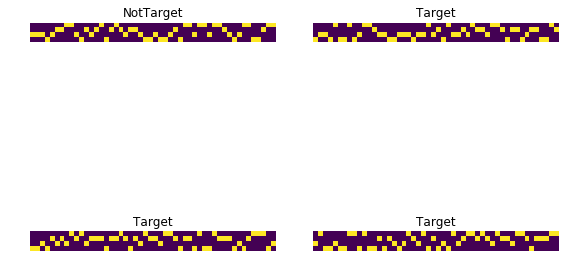

In [100]:
data.show_batch(rows=2)

# Model setup

## Basic model for fastai training

In [101]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [102]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [103]:
drop_p = 0.2

In [124]:
net_basic_fastai = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [125]:
net_basic_fastai

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [126]:
# initialize weights with kaiming normal initialization
apply_init(net_basic_fastai, nn.init.kaiming_normal_)

# Model training

## Train basic model with fastai

In [127]:
learn = Learner(data, net_basic_fastai, loss_func=F.binary_cross_entropy_with_logits, metrics=accuracy_thresh)

In [128]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 4, 50]          0          False     
______________________________________________________________________
Conv1d               [64, 32, 39]         1568       True      
______________________________________________________________________
MaxPool1d            [64, 32, 9]          0          False     
______________________________________________________________________
Lambda               [64, 288]            0          False     
______________________________________________________________________
Dropout              [64, 288]            0          False     
______________________________________________________________________
Linear               [64, 16]             4624       True      
______________________________________________________________________
ReLU                 [64, 16]             0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


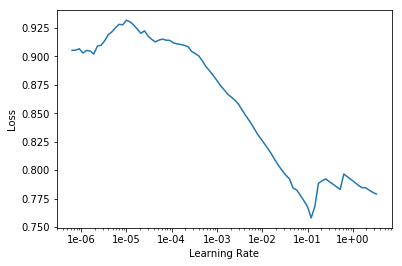

In [129]:
learn.lr_find()
learn.recorder.plot()

In [130]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.758463,0.674068,0.570000
2,0.681113,0.528719,0.756000
3,0.571919,0.352577,0.860000
4,0.435504,0.188524,0.932000
5,0.317464,0.118755,0.964000
6,0.233903,0.075277,0.977000
7,0.169943,0.075914,0.973000
8,0.128402,0.073212,0.970000
9,0.096706,0.064363,0.973000
10,0.077628,0.064303,0.973000


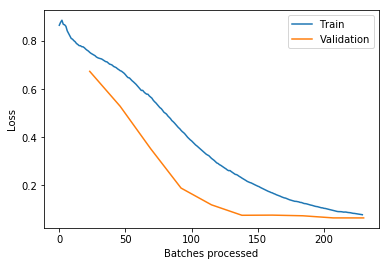

In [131]:
learn.recorder.plot_losses()

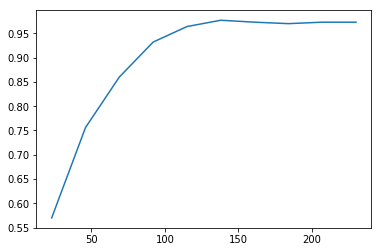

In [132]:
learn.recorder.plot_metrics()

In [110]:
learn.fit(10, lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.684701,0.642826,0.621000
2,0.621306,0.520933,0.785000
3,0.501336,0.288098,0.874000
4,0.361352,0.152649,0.940000
5,0.245224,0.077607,0.977000
6,0.172959,0.056026,0.982000
7,0.118301,0.056117,0.985000
8,0.080511,0.042544,0.990000
9,0.057612,0.050496,0.985000
10,0.043342,0.040375,0.985000


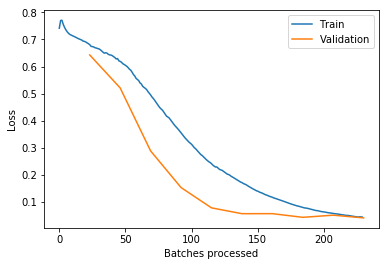

In [111]:
learn.recorder.plot_losses()

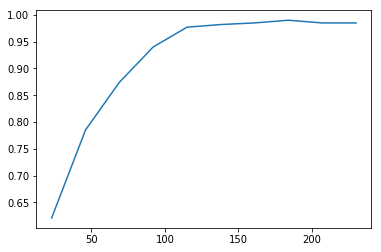

In [112]:
learn.recorder.plot_metrics()

# Interpretation

In [117]:
interpret = learn.interpret()

In [133]:
#interpret.confusion_matrix() # does not work yet!